# Exercise 1

The goal of this exercise is to estimate the 3D rotation of an object from a 2D image using a learning-based global descriptor. The idea is based on on:

```
M Sundermeyer, ZC Marton, M Durner, M Brucker, R Triebel
"Implicit 3d orientation learning for 6d object detection from rgb images"
European Conference on Computer Vision. Springer International Publishing, 2018.
https://arxiv.org/abs/1902.01275
```

Read the paper and try to understand the presented concepts. Under the assumption that we have already detected the object in 2D, we intend to estimate the 3D rotation by finding the most similar image in a set of reference images. We achieve this by conducting a nearest neighbor search in feature space using the cosine-similarity as distance metric. 

<img src="data/nn_search.png">


## Task 1

<img src="data/architecture.png">

Build the given network architecture with Pytorch. Train the network using the ADAM optimizer with the given training images by employing the MSE (mean squared error) loss. We already provide you with a corresponding dataloader.

In [21]:
import torch
import os
import collections
from pathlib import Path

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_channel, latent_size, img_dims):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channel, 32, 5, 2, 2), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
                                 nn.Conv2d(32, 64, 5, 2, 2), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
                                 nn.Conv2d(64, 64, 5, 2, 2), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
                                 nn.Conv2d(64, 128, 5, 2, 2), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        
        self.fc = nn.Linear((img_dims[0]*img_dims[1])//2, 64)
        
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        
        return x
        

class Decoder(nn.Module):
    def __init__(self, latent_size, img_dims):
        super().__init__()
        self.img_dims = img_dims
        self.fc = nn.Linear(latent_size, (img_dims[0] * img_dims[1])//2)
                
        self.net = nn.Sequential(nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
                                 nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
                                 nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
                                 nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
                                 nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid())

        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, self.img_dims[0]//16, self.img_dims[1]//16).contiguous()
        x = self.net(x)
        
        return x
    
class AAE(nn.Module):
    def __init__(self, in_channels, latent_size, img_shape):
        super().__init__()
        c = img_shape[0]
        shape = img_shape[1::]
        
        self.encoder = Encoder(in_channels, latent_size, shape)
        self.decoder = Decoder(latent_size, shape)        
    
    def encode(self, x):
        return self.encoder(x)
        
    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def postprocess(self, img):
        img = img * 255.0
        img = img.permute(0, 2, 3, 1)
        return img.int()
    
def GetLossFunction():
    return  torch.nn.MSELoss()

In [22]:
from src.dataloader import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os

# for reading files
def get_file_in_folder(path):
    files =[]
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(path, filename))
        break   
    return files

# seeding
seed=10
np.random.seed(seed)

# path to training images
dataset_path = 'data/Ex7/images'

# create dataset
dataset = Dataset(get_file_in_folder(os.path.join(dataset_path,"input")), 
                  get_file_in_folder(os.path.join(dataset_path, "gt")))


img_shape = (3, 64, 64)
latent_size = 64

# create model
model = AAE(3, latent_size, img_shape)
model.train()
loss_func = GetLossFunction()
if torch.cuda.is_available():
    model = model.cuda()
    
# optimizer
lr = 1e-4
opt = torch.optim.Adam(model.parameters(),lr=lr)

# create dataloader    
batchsize = 32
loader = DataLoader(
        dataset=dataset,
        batch_size=batchsize,
        num_workers=4,
        drop_last=True,
        shuffle=True,
)

iteration = 0
max_iterations = 10000
while iteration <= max_iterations:
    for sample in loader:
        
        x = sample['input']
        y = sample['gt']

        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        opt.zero_grad()
        y_ = model(x)
        loss = loss_func(y_,y)
        loss.backward()
        opt.step()
        if iteration % 1000 == 0:
            print('\riter {}, loss {}'.format (iteration, loss.item()))
              
        iteration += 1
        
model.eval()

iter 0, loss 0.2604738771915436
iter 1000, loss 0.011012096889317036
iter 2000, loss 0.006463568191975355
iter 3000, loss 0.004440862685441971
iter 4000, loss 0.004112820141017437
iter 5000, loss 0.003339215647429228
iter 6000, loss 0.003442891640588641
iter 7000, loss 0.0026931483298540115
iter 8000, loss 0.0029478592332452536
iter 9000, loss 0.0022851910907775164
iter 10000, loss 0.00231256359256804


AAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2)
    )
    (fc): Linear(in_features=2048, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear

In [24]:
# torch.save(model.state_dict(), "aae.pth")

## Task 2

Use the encoder part of the network to build up a codebook for all the reference images in ```images_ref```. In particular, take each image feed it to the encoder and save the descriptor it in a list.

In [52]:
import cv2
import open3d as o3d
import torchvision.transforms as transforms
import os
import PIL

if os.path.exists("aae.pth"):
    img_shape = (3, 64, 64)
    latent_size = 64
    model = AAE(3, latent_size, img_shape)
    model.load_state_dict(torch.load("aae.pth"))
    model.eval()

# path to training images
dataset_ref_path = 'data/Ex7/images_ref'

# for reading files
def get_file_in_folder(path):
    files =[]
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(path, filename))
        break   
    return files

ref_images = get_file_in_folder(dataset_ref_path)
print('num of ref images:', len(ref_images))

codebook = []
for image in ref_images:
    
    # preprocess image as in the data loader
    x = cv2.imread(image, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = PIL.Image.fromarray(x)

    x = transforms.ToTensor()(x).float()
    x = x.unsqueeze(0)
    
    # compute the descriptor for each sample
    descriptor = model.encoder(x)
    descriptor = descriptor.squeeze(0).detach().numpy().astype(np.float64)
    
    # add it to the codebook
    codebook.append(descriptor)


num of ref images: 42
Done codebook


(64, 42)

## Task 3

For each test image, compute the latent code and find the 3 closest descriptors and their indices from the codebook by using k-nearest neighbor approach. Show the paired query image and the reconstructed image from the corresponding code from the codebook.

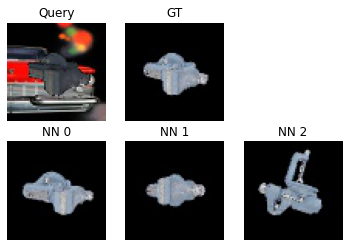

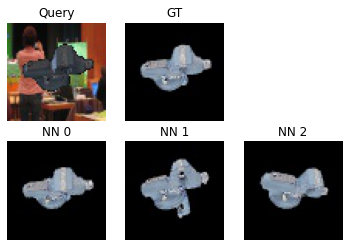

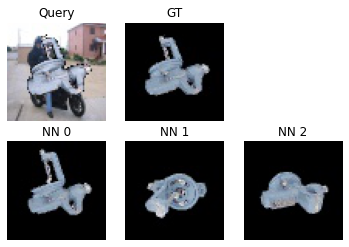

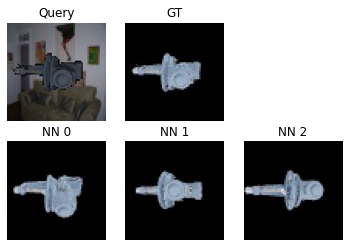

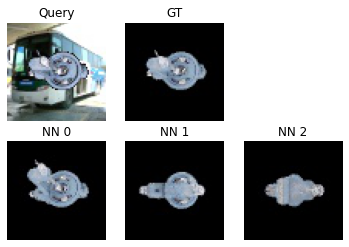

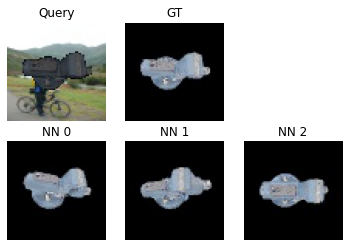

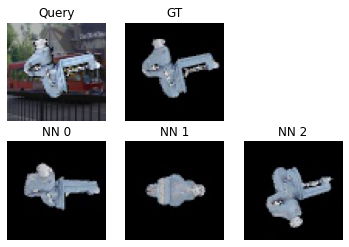

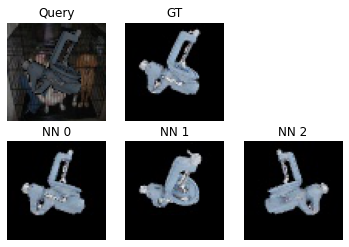

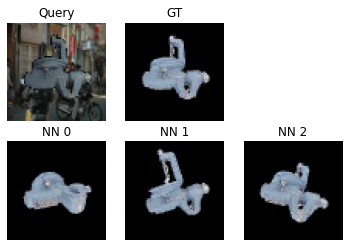

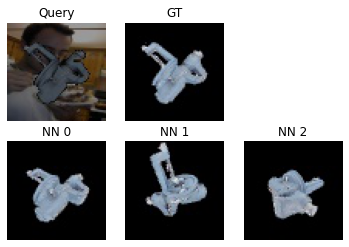

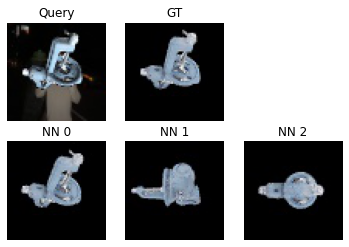

In [85]:
from matplotlib import pyplot as plt
%matplotlib inline

tree = o3d.geometry.KDTreeFlann(np.asarray(codebook).T)
num_neighbors = 3

iteration=0

# path to training images
dataset_path = 'data/Ex7/images_test'

# create dataset
dataset = Dataset(get_file_in_folder(os.path.join(dataset_path,"input")), 
                  get_file_in_folder(os.path.join(dataset_path, "gt")))

for i in range(len(dataset)):
    sample = dataset.load_item(i)
    
    x = sample['input'].unsqueeze(0)
    y = sample['gt'].unsqueeze(0)
    
    if torch.cuda.is_available():
        x= x.cuda()
        y= y.cuda()
    
    # compute descriptor for sample
    descriptor = model.encoder(x)
    descriptor = descriptor.permute(1, 0).detach().numpy().astype(np.float64)

    # find closet neighbors using knn
    [k, idx, _] = tree.search_knn_vector_xd(descriptor, num_neighbors)
    
    # decode nearest neighbors and postprocess using model.postprocess
    nn_imgs = [ref_images[index] for index in idx]
    
    for j in range(len(nn_imgs)):
        img = nn_imgs[j]
        nn = cv2.imread(img, cv2.IMREAD_COLOR)
        nn = cv2.cvtColor(nn, cv2.COLOR_BGR2RGB)
        nn = PIL.Image.fromarray(nn)
        nn = transforms.ToTensor()(nn)
        nn = nn.unsqueeze(0)
        nn = model.postprocess(nn)[0].detach().numpy()
        
        nn_imgs[j] = nn
    
    # plot Query, GT and the nearest neighbors as shown on the top
    plt.subplot(2, num_neighbors, 1)
    plt.title("Query")
    plt.axis("off")
    plt.imshow(x[0].permute(1, 2, 0).detach().numpy())
    
    plt.subplot(2, num_neighbors, 2)
    plt.title("GT")
    plt.axis("off")
    plt.imshow(y[0].permute(1, 2, 0).detach().numpy())
    
    for k in range(len(nn_imgs)):
        plt.subplot(2, num_neighbors, num_neighbors + k + 1)
        plt.title("NN %i" % k)
        plt.axis("off")
        plt.imshow(nn_imgs[k])
    
    plt.show()